In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.induction_pinn import PINN, numpy_to_tensor, train, init_weights
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

In [2]:
def plot_data(df: pd.DataFrame):
    plt.figure(figsize=(12, 3))
    plt.scatter(df['RTime'], df['Biomass'], s=10, label='Biomass')
    plt.scatter(df['RTime'], df['Glucose'], s=10, label='Glucose')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.scatter(df['RTime'], df['Protein'], s=10, label='Protein')
    plt.scatter(df['RTime'], df['V'], s=10, label='Volume')
    plt.legend()
    plt.show()

In [3]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR02'

df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Get FB and FBI data
df = df[df['Process'] == 'FBI']
feeds = feeds[feeds['Induction']==1]

print(f'Dataset shape: {df.shape}')

Dataset shape: (8, 8)


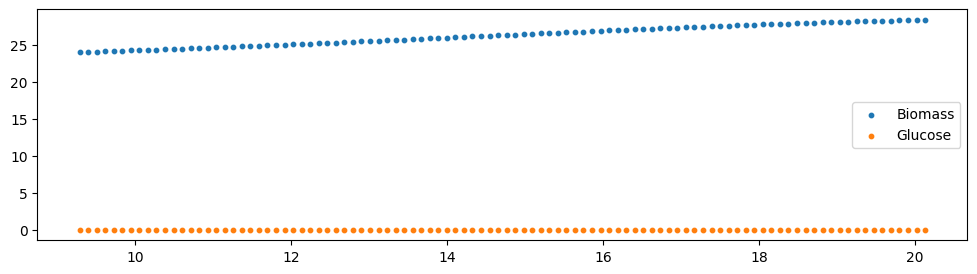

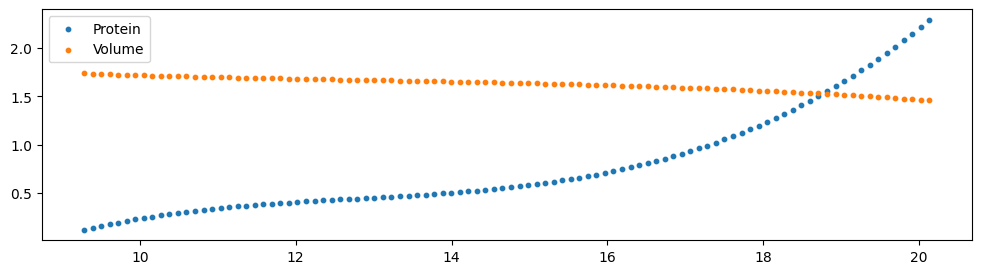

In [4]:
# Fit a polynomial to the data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

t_start = df['RTime'].min() 
t_end = df['RTime'].max()

t_train = df['RTime'].values.reshape(-1, 1)
X_train = df['Biomass'].values.reshape(-1, 1)
S_train = df['Glucose'].values.reshape(-1, 1)
P_train = df['Protein'].values.reshape(-1, 1)
V_train = df['V'].values.reshape(-1, 1)

# Polynomial features
poly = PolynomialFeatures(degree=3)
t_train_poly = poly.fit_transform(t_train)

# Fit the polynomial
reg_X = LinearRegression().fit(t_train_poly, X_train)
reg_S = LinearRegression().fit(t_train_poly, S_train)
reg_P = LinearRegression().fit(t_train_poly, P_train)
reg_V = LinearRegression().fit(t_train_poly, V_train)

df_sim = pd.DataFrame()
t_sim = np.linspace(t_start, t_end, 100)
t_sim_poly = poly.transform(t_sim.reshape(-1, 1))
df_sim['RTime'] = t_sim
df_sim['Biomass'] = reg_X.predict(t_sim_poly) 
df_sim['Glucose'] = reg_S.predict(t_sim_poly)
df_sim['Protein'] = reg_P.predict(t_sim_poly)
df_sim['V'] = reg_V.predict(t_sim_poly)

plot_data(df_sim)

In [5]:
df_sim.to_csv('../data/BR02_FBI_sim.csv', index=False)

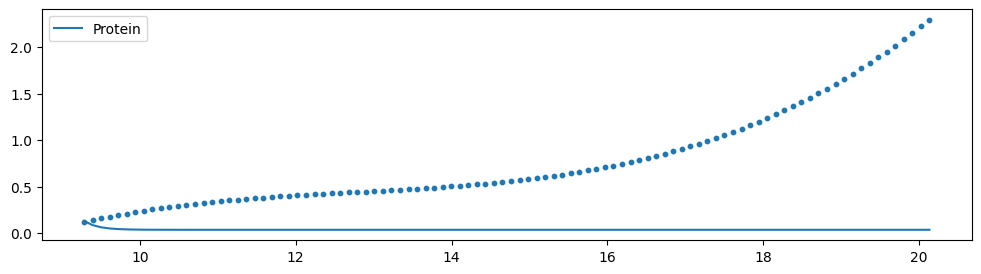

In [6]:
# create function to solve the Fed-batch ode
def fedbatch(t, y):
    # unpack the state variables
    X, S, V, P = y
    
    Sin = 1.43 * 200
    F = 10 / 1000
    mu = 0.88 * S / (0.216 + S)
    Yxs = 0.416
    a_max = 0.3
    c1 = 0.8
    c2 = 0.8
    c3 = 0.3
    alpha = a_max * (1 - np.exp(-(c1 * t**2 - c2 *t + c3)))

    dXdt = mu * X - F / V * X
    dSdt = - mu * X / Yxs + F / V * (Sin - S)
    dVdt = F
    dPdt = alpha * mu * X - F * 1000 / V * P 
    return [dXdt, dSdt, dVdt, dPdt]

tspan = (t_start, t_end)
t_eval = np.linspace(t_start, t_end, 100)
y0 = [X_train[0][0], S_train[0][0], V_train[0][0], P_train[0][0]]
sol = solve_ivp(fedbatch, tspan, y0=y0, t_eval=t_eval)

# Plot 
# plt.figure(figsize=(12, 3))
# plt.plot(sol.t, sol.y[0], label='Biomass')
# plt.scatter(df_sim['RTime'], df_sim['Biomass'], s=10)
# plt.plot(sol.t, sol.y[1], label='Glucose')
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 3))
plt.plot(sol.t, sol.y[3], label='Protein')
plt.scatter(df_sim['RTime'], df_sim['Protein'], s=10)
plt.legend()
plt.show()

In [7]:
import torch
import torch.nn as nn

def ode_loss(net, t):

    t = torch.linspace(t.min(), t.max(), steps=50).view(-1,1).requires_grad_(True)
    Sin = 1.43 * 200

    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].reshape(-1, 1)
    S_pred = u_pred[:, 1].reshape(-1, 1)
    V_pred = u_pred[:, 2].reshape(-1, 1)
    P_pred = u_pred[:, 3].reshape(-1, 1)

    dXdt = torch.autograd.grad(X_pred, t, torch.ones_like(X_pred), create_graph=True)[0]
    dSdt = torch.autograd.grad(S_pred, t, torch.ones_like(S_pred), create_graph=True)[0]
    dVdt = torch.autograd.grad(V_pred, t, torch.ones_like(V_pred), create_graph=True)[0]
    dPdt = torch.autograd.grad(P_pred, t, torch.ones_like(P_pred), create_graph=True)[0]

    Fs = 10.0 / 1000

    mu = net.mu_max * S_pred / (0.216 + S_pred)

    alpha = net.c1 * (1 - torch.exp(-net.c2 * t))

    error_dXdt = nn.MSELoss()(
        dXdt, mu * X_pred - X_pred * Fs  / V_pred
    )
    error_dSdt = nn.MSELoss()(
        dSdt, (- mu * X_pred / 0.416 + Fs / V_pred * (Sin - S_pred)) 
    )
    error_dVdt = nn.MSELoss()(
        dVdt, torch.ones_like(dVdt) * Fs
    )
    error_dPdt = nn.MSELoss()(
        dPdt, alpha * mu * X_pred - P_pred * 0.001 * Fs  / V_pred
    )

    # error_ode = error_dXdt + error_dSdt + error_dVdt + error_dPdt

    error_ode = error_dVdt + error_dXdt

    return error_ode

class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, output_dim)

        self.mu_max = nn.Parameter(torch.tensor([0.8]))

        self.c1 = nn.Parameter(torch.tensor([1.0]))
        self.c2 = nn.Parameter(torch.tensor([1.0]))
        self.c3 = nn.Parameter(torch.tensor([1.0]))
        self.c4 = nn.Parameter(torch.tensor([1.0]))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2(x))
        x = self.fc4(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(1, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Load the data
t_train = numpy_to_tensor(df_sim['RTime'].values)
X_train = numpy_to_tensor(df_sim['Biomass'].values)
S_train = numpy_to_tensor(df_sim["Glucose"].values)
P_train = numpy_to_tensor(df_sim["Protein"].values)
V_train = numpy_to_tensor(df_sim["V"].values)

u_train = torch.cat((X_train, S_train, V_train, P_train), dim=1).to(device)

# Train the model
n_epochs = 3000
pbar = tqdm(total=n_epochs)
for epoch in range(n_epochs):
    optimizer.zero_grad()
    u_pred = model.forward(t_train)
    
    loss_data = nn.MSELoss()(u_pred, u_train) 
    loss_ode = ode_loss(model, t_train) 
    
    if loss_ode.item() < 0.05 and epoch >=1000:
        loss_ode = torch.tensor([0.0])
        loss = loss_data        
    else:
        loss = loss_data + loss_ode
        
    loss.backward()
    optimizer.step()

    # # Early stopping
    if loss < 0.001:
        break
    
    if epoch % 100 == 0:
        pbar.set_description(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item():.4f} | ODE Loss: {loss_ode.item():.4f}')
        pbar.update(100)
pbar.close()

Epoch 2900/3000, Loss: 4.3032 | ODE Loss: 0.0000: 100%|██████████| 3000/3000 [02:00<00:00, 24.87it/s] 


In [8]:
model.mu_max.item(), model.c1.item(), model.c2.item(), model.c3.item()

(0.7995945811271667, 1.0, 1.0, 1.0)

Epoch 900/1000, Loss: 0.0041 | ODE Loss: 499.6524
100%|██████████| 1000/1000 [00:05<00:00, 170.30it/s]


In [11]:
net_df = pd.DataFrame()
net_df['RTime'] = t_train.cpu().detach().numpy().flatten()
net_df['Biomass'] = model.forward(t_train)[:,0].cpu().detach().numpy().flatten()
net_df['Glucose'] = model.forward(t_train)[:,1].cpu().detach().numpy().flatten()
net_df['V'] = model.forward(t_train)[:,2].cpu().detach().numpy().flatten()
net_df['Protein'] = model.forward(t_train)[:,3].cpu().detach().numpy().flatten()


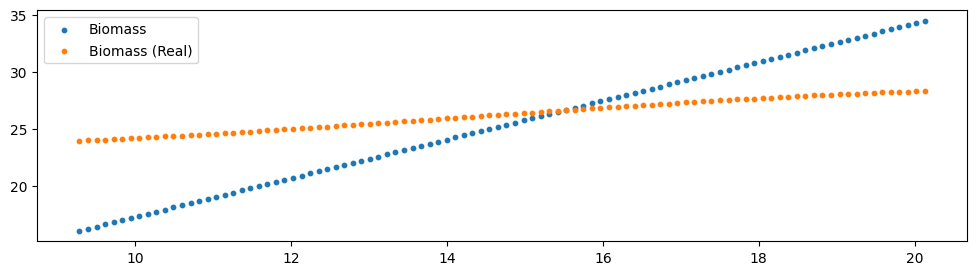

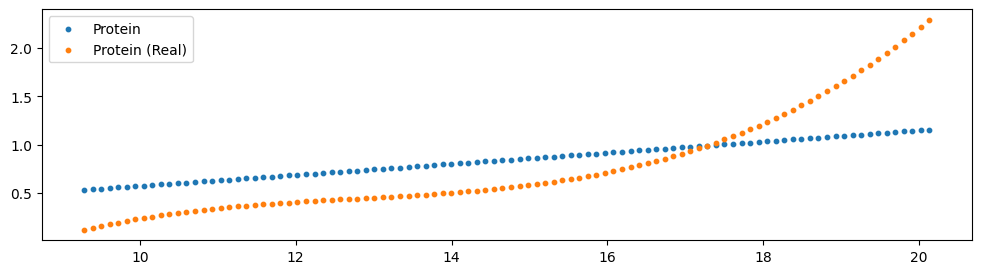

In [12]:
plt.figure(figsize=(12, 3))
plt.scatter(net_df['RTime'], net_df['Biomass'], s=10, label='Biomass')
plt.scatter(df_sim['RTime'], df_sim['Biomass'], s=10, label='Biomass (Real)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.scatter(net_df['RTime'], net_df['Protein'], s=10, label='Protein')
plt.scatter(df_sim['RTime'], df_sim['Protein'], s=10, label='Protein (Real)')
plt.legend()
plt.show()
